In [7]:
!pip install matplotlib seaborn pandas pyspark

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 47.8 MB/s  0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 49.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 41.3 MB/s  0:00:00
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]


In [2]:
# EDA: Setup & Load
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.appName("ISD_2024_EDA").getOrCreate()

PARQUET_PATH = "../data/cleansed/2024_cleansed.parquet"  
df = spark.read.parquet(PARQUET_PATH)

print("Loaded:", PARQUET_PATH)
df.printSchema()
print("Rows:", f"{df.count():,}")

Loaded: ../data/cleansed/2024_cleansed.parquet
root
 |-- STATION: integer (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- WND_DIR_DEG: double (nullable = true)
 |-- WND_TYPE: string (nullable = true)
 |-- WND_SPD_MS: double (nullable = true)
 |-- CIG_HEIGHT_M: double (nullable = true)
 |-- VIS_DIST_M: double (nullable = true)
 |-- TMP_C: double (nullable = true)
 |-- DEW_C: double (nullable = true)
 |-- SLP_hPa: double (nullable = true)

Rows: 18,753,612


In [3]:
num_cols = ["WND_DIR_DEG", "WND_SPD_MS", "CIG_HEIGHT_M", "VIS_DIST_M", "TMP_C","DEW_C","SLP_hPa"]
df.select(*num_cols).describe().show()

25/10/13 23:49:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|       WND_DIR_DEG|        WND_SPD_MS|      CIG_HEIGHT_M|        VIS_DIST_M|             TMP_C|             DEW_C|           SLP_hPa|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|          18753612|          18753612|          18753612|          18753612|          18753612|          18753612|          18753612|
|   mean|218.17159638367264|3.9748105968949687|  11616.0931094234| 17406.77611822192|13.177627819138234| 6.897972694536801|1013.8133491086074|
| stddev|176.21843663741038| 2.543799007589421|10224.741002185187|11347.489035962455|12.567802303690847|11.484764495160706| 8.843220768715485|
|    min|               1.0|               0.0|               0.0|               0.0|             -79.0|             -83.0|             861.1|

In [4]:
# Null counts per column (Spark)
null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T
null_counts.columns = ["null_count"]
null_counts = null_counts.sort_values("null_count", ascending=False)
null_counts.head(20)

,null_count
STATION,18717396
WND_DIR_DEG,0
DEW_C,0
TMP_C,0
VIS_DIST_M,0
CIG_HEIGHT_M,0
WND_SPD_MS,0
WND_TYPE,0
ELEVATION,0
DATE,0


In [5]:
# Sample a tiny fraction for plotting to avoid memory issues
# Adjust fraction if you want more/less points in plots
SAMPLE_FRAC = 0.001   # 0.1% — change to 0.002 or 0.005 if you want denser plots
SAMPLE_SEED = 42

plot_cols = ["TMP_C","DEW_C","SLP_hPa","WND_SPD_MS","VIS_DIST_M","CIG_HEIGHT_M","hour","month"]
sample_pdf = (
    df.select(*[c for c in plot_cols if c in df.columns])
      .sample(False, SAMPLE_FRAC, seed=SAMPLE_SEED)
      .toPandas()
)

sample_pdf.head()

,TMP_C,DEW_C,SLP_hPa,WND_SPD_MS,VIS_DIST_M,CIG_HEIGHT_M,hour,month
0,-2.7,-3.9,1022.7,3.1,30000.0,200.0,6,5
1,7.7,5.1,1001.0,5.1,50000.0,100.0,15,7
2,-2.7,-8.3,1026.2,1.4,50000.0,1000.0,0,5
3,-10.8,-13.4,966.0,8.0,500.0,120.0,12,1
4,-6.7,-10.0,1007.4,4.0,65000.0,22000.0,6,2


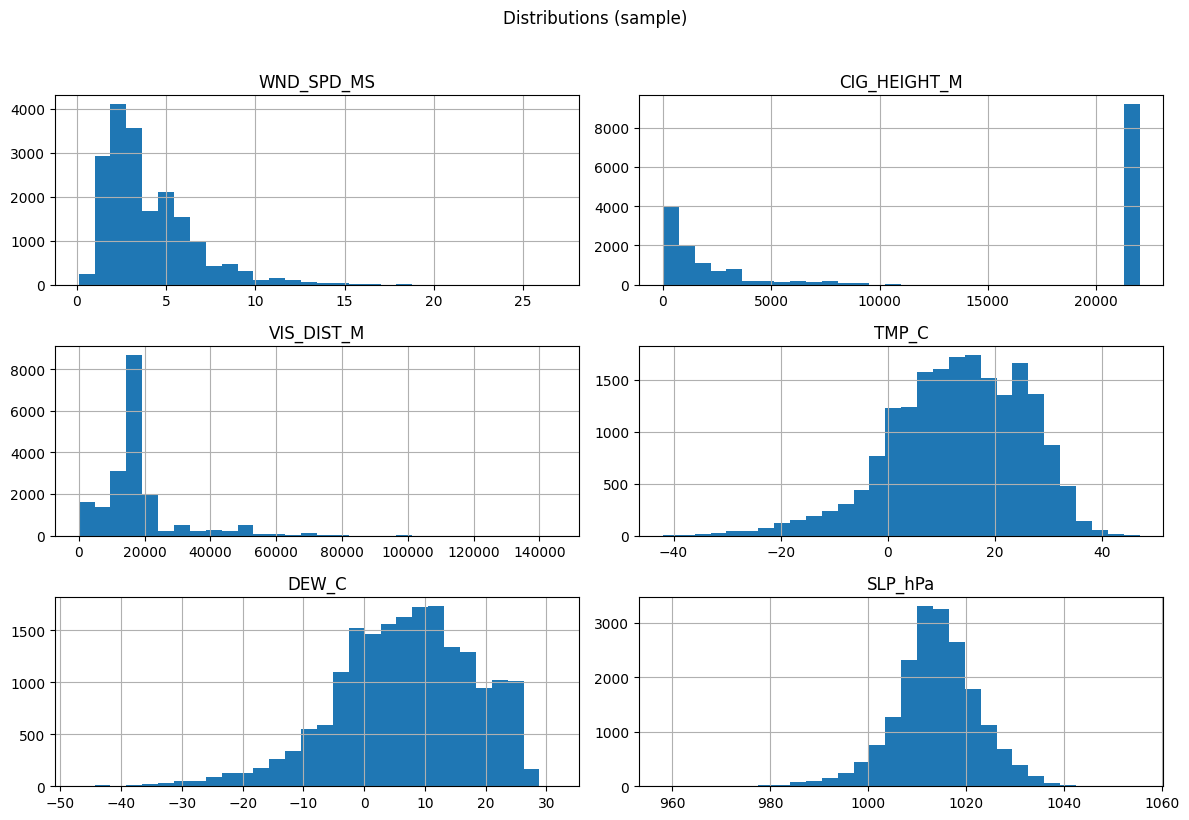

In [10]:
# Histograms of key numeric variables
import matplotlib.pyplot as plt

cols_for_hist = ["WND_SPD_MS", "CIG_HEIGHT_M", "VIS_DIST_M", "TMP_C","DEW_C","SLP_hPa"]
sample_pdf[cols_for_hist].hist(bins=30, figsize=(12,8))
plt.suptitle("Distributions (sample)", y=1.02)
plt.tight_layout()
plt.show()

                 TMP_C     DEW_C   SLP_hPa  WND_SPD_MS  VIS_DIST_M  \
TMP_C         1.000000  0.867191 -0.147287   -0.097573   -0.006363   
DEW_C         0.867191  1.000000 -0.155877   -0.148824   -0.049016   
SLP_hPa      -0.147287 -0.155877  1.000000   -0.199770    0.028402   
WND_SPD_MS   -0.097573 -0.148824 -0.199770    1.000000   -0.018857   
VIS_DIST_M   -0.006363 -0.049016  0.028402   -0.018857    1.000000   
CIG_HEIGHT_M  0.216628  0.006551  0.158649   -0.101939    0.109653   

              CIG_HEIGHT_M  
TMP_C             0.216628  
DEW_C             0.006551  
SLP_hPa           0.158649  
WND_SPD_MS       -0.101939  
VIS_DIST_M        0.109653  
CIG_HEIGHT_M      1.000000  


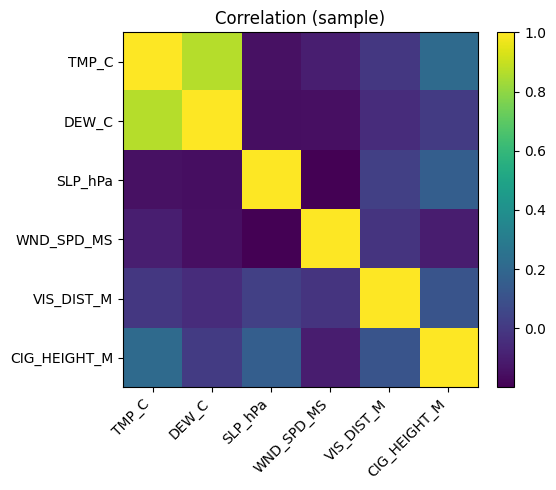

In [11]:
import numpy as np
import matplotlib.pyplot as plt

corr_cols = ["TMP_C","DEW_C","SLP_hPa","WND_SPD_MS","VIS_DIST_M","CIG_HEIGHT_M"]
corr = sample_pdf[corr_cols].corr()

print(corr)

# Heatmap
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr.values, interpolation="nearest")
ax.set_xticks(np.arange(len(corr_cols))); ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticks(np.arange(len(corr_cols))); ax.set_yticklabels(corr_cols)
ax.set_title("Correlation (sample)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [12]:
# Average temperature by hour
avg_by_hour = (df.groupBy("hour").agg(F.avg("TMP_C").alias("avg_tmp"))
                 .orderBy("hour")).toPandas()

# Average temperature by month
avg_by_month = (df.groupBy("month").agg(F.avg("TMP_C").alias("avg_tmp"))
                  .orderBy("month")).toPandas()

avg_by_hour.head(), avg_by_month.head()

(   hour    avg_tmp
 0     0  13.934887
 1     1  12.191342
 2     2  11.581506
 3     3  12.925933
 4     4  10.457914,
    month    avg_tmp
 0      1   2.377144
 1      2   5.988227
 2      3   8.218627
 3      4  12.461415
 4      5  16.689591)

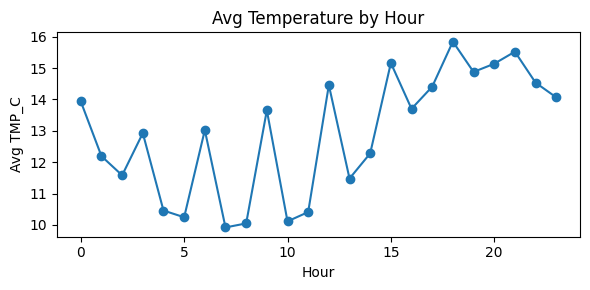

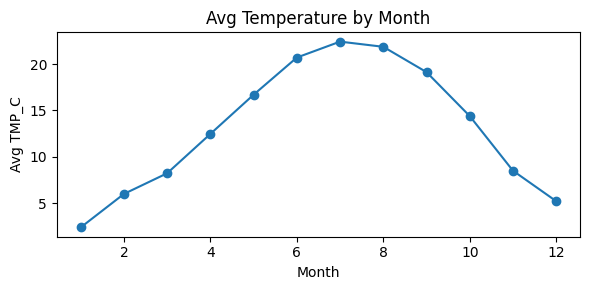

In [13]:
import matplotlib.pyplot as plt

# Plot hourly pattern
plt.figure(figsize=(6,3))
plt.plot(avg_by_hour["hour"], avg_by_hour["avg_tmp"], marker="o")
plt.xlabel("Hour"); plt.ylabel("Avg TMP_C"); plt.title("Avg Temperature by Hour")
plt.tight_layout(); plt.show()

# Plot monthly pattern
plt.figure(figsize=(6,3))
plt.plot(avg_by_month["month"], avg_by_month["avg_tmp"], marker="o")
plt.xlabel("Month"); plt.ylabel("Avg TMP_C"); plt.title("Avg Temperature by Month")
plt.tight_layout(); plt.show()

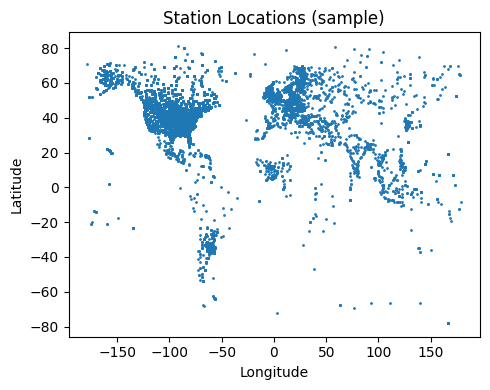

In [14]:
# Scatter of station locations if many stations present
geo_cols_present = all(c in df.columns for c in ["LATITUDE","LONGITUDE"])
if geo_cols_present:
    geo_sample = df.select("LATITUDE","LONGITUDE").dropna().sample(False, 0.0005, seed=42).toPandas()
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5,4))
    plt.scatter(geo_sample["LONGITUDE"], geo_sample["LATITUDE"], s=1)
    plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.title("Station Locations (sample)")
    plt.tight_layout(); plt.show()
else:
    print("LATITUDE/LONGITUDE not available for scatter.")

In [ ]:
# Save summary tables for report reproducibility
from pathlib import Path
out_dir = Path("../artifacts/eda"); out_dir.mkdir(parents=True, exist_ok=True)

df.describe(["TMP_C","DEW_C","SLP_hPa","WND_SPD_MS","VIS_DIST_M","CIG_HEIGHT_M"]).toPandas() \
  .to_csv(out_dir / "describe_numeric.csv", index=False)

avg_by_hour.to_csv(out_dir / "avg_tmp_by_hour.csv", index=False)
avg_by_month.to_csv(out_dir / "avg_tmp_by_month.csv", index=False)

print("EDA tables saved under:", out_dir.resolve())

✅ EDA tables saved under: /Users/astraeasim/Desktop/DSA5208_mllib-weather-predictor/artifacts/eda
